In [2]:
%pip install kaggle --quiet
!kaggle datasets download -d mohammedalrajeh/quran-recitations-for-audio-classification

import zipfile
from pathlib import Path

zip_path = Path("quran-recitations-for-audio-classification.zip")
out_dir = Path("quran-recitations-for-audio-classification")

out_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path) as z:
    z.extractall(out_dir)



Note: you may need to restart the kernel to use updated packages.


Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification
License(s): unknown




  0%|          | 0.00/2.12G [00:00<?, ?B/s]
  4%|▍         | 95.0M/2.12G [00:00<00:02, 995MB/s]
  9%|▉         | 191M/2.12G [00:00<00:02, 986MB/s] 
 14%|█▍        | 307M/2.12G [00:00<00:01, 1.09GB/s]
 19%|█▉        | 420M/2.12G [00:00<00:01, 1.12GB/s]
 24%|██▍       | 528M/2.12G [00:00<00:01, 1.12GB/s]
 30%|██▉       | 646M/2.12G [00:00<00:01, 1.16GB/s]
 35%|███▌      | 762M/2.12G [00:00<00:01, 1.18GB/s]
 40%|████      | 878M/2.12G [00:00<00:01, 1.19GB/s]
 46%|████▌     | 997M/2.12G [00:00<00:01, 1.20GB/s]
 51%|█████▏    | 1.09G/2.12G [00:01<00:00, 1.21GB/s]
 57%|█████▋    | 1.20G/2.12G [00:01<00:00, 1.22GB/s]
 62%|██████▏   | 1.32G/2.12G [00:01<00:00, 1.22GB/s]
 68%|██████▊   | 1.44G/2.12G [00:01<00:00, 754MB/s] 
 73%|███████▎  | 1.55G/2.12G [00:01<00:00, 840MB/s]
 79%|███████▊  | 1.66G/2.12G [00:01<00:00, 931MB/s]
 84%|████████▍ | 1.78G/2.12G [00:01<00:00, 1.02GB/s]
 90%|████████▉ | 1.90G/2.12G [00:01<00:00, 1.09GB/s]
 96%|█████████▌| 2.02G/2.12G [00:02<00:00, 1.14GB/s]
100%|███████

In [3]:
# Delete the zip file after successful extraction
if zip_path.exists():
    zip_path.unlink()
    print("Zip file deleted successfully.")
else:
    print("Zip file not found.")

Zip file deleted successfully.


In [1]:
import torch
import librosa
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
data_df = pd.read_csv("quran-recitations-for-audio-classification/files_paths.csv")

print(data_df["Class"].unique())
print(len(data_df["Class"].unique()))

data_df.head()

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [3]:
data_df["FilePath"] = "quran-recitations-for-audio-classification/Dataset" + data_df["FilePath"].str[1:]
data_df.head()

,FilePath,Class
0,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
1,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
2,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
3,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
4,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan


Data Shape:  (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64



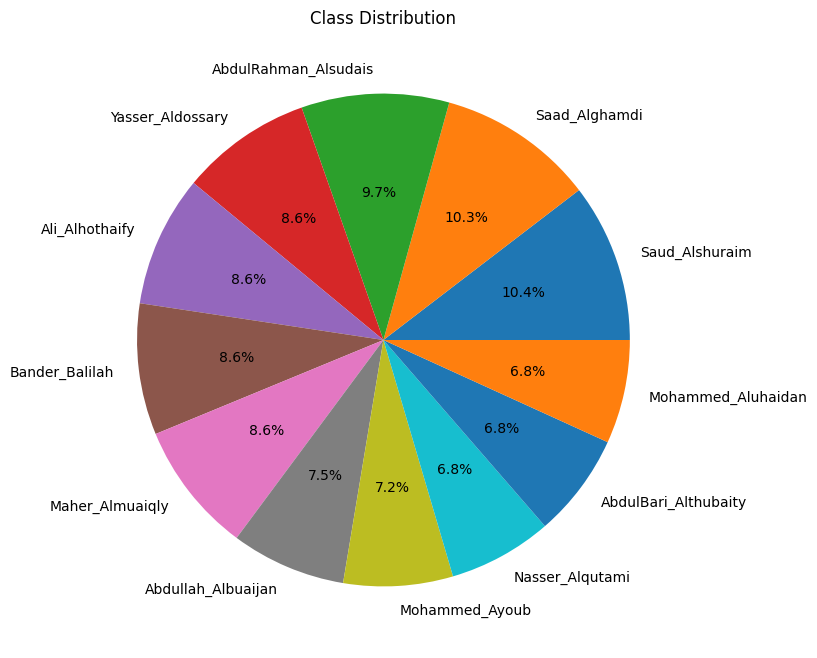

In [4]:
print("Data Shape: ", data_df.shape)
print("Class Distribution: ", data_df["Class"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(data_df["Class"].value_counts(), labels = data_df["Class"].value_counts().index, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

In [5]:
label_endoder = LabelEncoder()
data_df["Class"] = label_endoder.fit_transform(data_df["Class"])

train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=7)
test = test.drop(val.index)

print("Train Shape: ", train.shape)
print("Val Shape: ", val.shape)
print("Test Shape: ", test.shape)

Train Shape:  (4681, 2)
Val Shape:  (1003, 2)
Test Shape:  (1003, 2)


In [17]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe["FilePath"]]
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label
    
    def get_spectogram(self, file_path):
        sr = 22050
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr = sr, duration=duration)

        spec = librosa.feature.melspectrogram(y = signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_resized = librosa.util.fix_length(spec_db, size=(duration * sr) // 512 + 1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized



In [18]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [19]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64 * 16 * 32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, len(data_df["Class"].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pooling(self.conv1(x))
        x = self.pooling(self.conv2(x))
        x = self.pooling(self.conv3(x))
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)
        return x




In [23]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [24]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

import time
start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for input, labels in train_loader:
        outputs = model(input)
        loss = criterion(outputs, labels)
        total_loss_train += loss.item()
        loss.backward()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += acc

        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for input, labels in val_loader:
            outputs = model(input)
            loss = criterion(outputs, labels)
            total_loss_val += loss.item()

            acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += acc
    
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset) * 100, 4))
    total_acc_val_plot.append(round(total_acc_val/len(val_dataset) * 100, 4))
    print(f"Epoch: {epoch + 1}/{EPOCHS} | Training Loss: {round(total_loss_train/1000, 4)} | Training Accuracy: {round(total_acc_train/len(train_dataset) * 100, 4)}% | Validation Loss: {round(total_loss_val/1000, 4)} | Validation Accuracy: {round(total_acc_val/len(val_dataset) * 100, 4)}%")
    print("-" * 100)

print(f"Total Training Time: {round((time.time() - start_time) / 60, 2)} minutes")

Epoch: 1/25 | Training Loss: 0.7099 | Training Accuracy: 44.3922% | Validation Loss: 0.0403 | Validation Accuracy: 79.7607%
------------------------------------------------------------
Epoch: 2/25 | Training Loss: 0.1435 | Training Accuracy: 85.2168% | Validation Loss: 0.0186 | Validation Accuracy: 90.2293%
------------------------------------------------------------
Epoch: 3/25 | Training Loss: 0.0791 | Training Accuracy: 91.5403% | Validation Loss: 0.0131 | Validation Accuracy: 93.6191%
------------------------------------------------------------
Epoch: 4/25 | Training Loss: 0.0548 | Training Accuracy: 94.3602% | Validation Loss: 0.014 | Validation Accuracy: 93.2203%
------------------------------------------------------------
Epoch: 5/25 | Training Loss: 0.039 | Training Accuracy: 96.1333% | Validation Loss: 0.0221 | Validation Accuracy: 91.4257%
------------------------------------------------------------
Epoch: 6/25 | Training Loss: 0.0343 | Training Accuracy: 96.3897% | Validatio

In [27]:
with torch.no_grad():
    total_acc_test = 0
    for input, labels in test_loader:
        outputs = model(input)
        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_test += acc

print(f"Test Accuracy: {round(total_acc_test/len(test_dataset) * 100, 4)}%")

Test Accuracy: 95.3141%


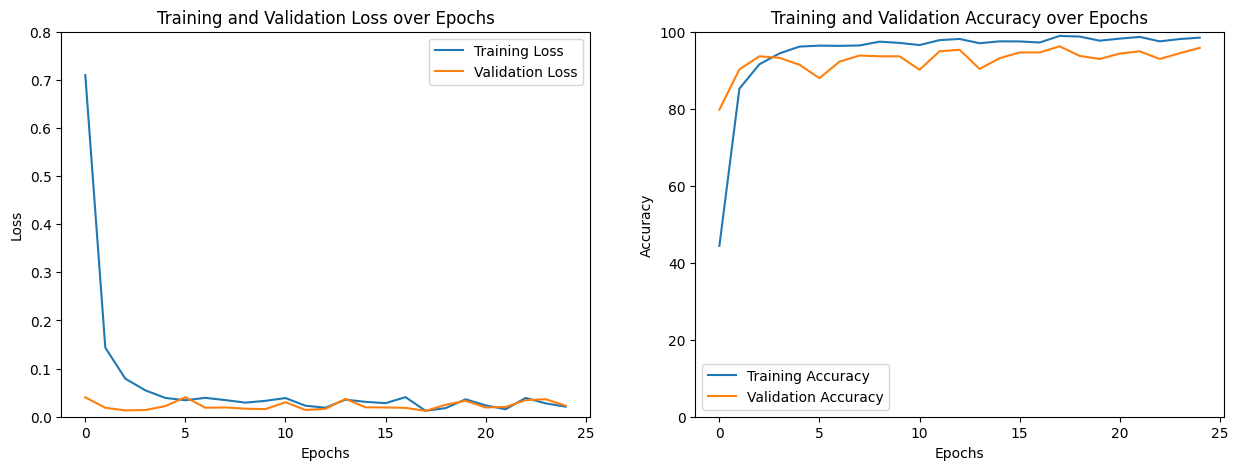

In [30]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotting loss over epochs
axis[0].plot(total_loss_train_plot, label="Training Loss")
axis[0].plot(total_loss_val_plot, label="Validation Loss")
axis[0].set_title("Training and Validation Loss over Epochs")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_ylim([0, 0.8])
axis[0].legend()

# Plotting accuracy over epochs
axis[1].plot(total_acc_train_plot, label="Training Accuracy")
axis[1].plot(total_acc_val_plot, label="Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy over Epochs")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_ylim([0, 100])
axis[1].legend()

plt.show()